In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from einops import rearrange
from tqdm import tqdm

from dataset.utils import process_FB

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


# Load & process dataset

## Use DynGESN

for more datasets:

https://github.com/dtortorella/dyngraphesn/tree/master

In [2]:
config = {
        'reservoir_size': 16,
        'input_scaling': 1,
        'reservoir_layers': 5,
        'leaking_rate': 0.1,
        'spectral_radius': 1,
        'density': 1,
        'reservoir_activation': 'tanh',
        'lr': 0.05,
        'epochs': 100,
        'alpha_decay': False,
        'add_self_loops': False,
        'b_leaking_rate': True,
        }

In [3]:
train_dataloader, test_dataloader, val_dataloader, states = process_FB(config, device, ignore_file=True, verbose=True)

Model saved to models/saved/DynGESN.pt
Running DynGESN model...


100%|██████████| 995/995 [02:28<00:00,  6.69it/s]


DynGESN model run complete.
Saving results to H5 file...
Saved results to H5 file.


### Train the readout

In [4]:
import numpy as np

inputs = []
labels = []

for batch in train_dataloader:
    input_batch, label_batch = batch
    inputs.append(input_batch.numpy())
    labels.append(label_batch.numpy())

inputs = np.concatenate(inputs)
labels = np.concatenate(labels)

test_inputs = []
test_labels = []

for batch in test_dataloader:
    test_input_batch, test_label_batch = batch
    test_inputs.append(test_input_batch.numpy())
    test_labels.append(test_label_batch.numpy())

test_inputs = np.concatenate(test_inputs)
test_labels = np.concatenate(test_labels)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.91


In [4]:
class LinearRegression(pl.LightningModule):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.accuracy = torchmetrics.classification.Accuracy(task="binary", num_classes=2)

    def forward(self, x):
        output = self.linear(x.float()).squeeze()
        # output = nn.functional.sigmoid(output)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.BCEWithLogitsLoss()(output, y.float())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.BCEWithLogitsLoss()(output, y.float())
        self.log('val_loss', loss)
        self.accuracy(output, y)
        self.log('val_acc_step', self.accuracy)

    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.BCEWithLogitsLoss()(output, y.float())
        self.log('test_loss', loss)
        self.accuracy(output, y)
        self.log('test_acc_step', self.accuracy)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=config['lr'])
        return optimizer


In [5]:
forecaster = LinearRegression(input_size=config['reservoir_size']*config['reservoir_layers'],
                              output_size=1).to(device)

In [ ]:
logger = TensorBoardLogger(save_dir="logs", name="dynGESN", version=0)
# %load_ext tensorboard
# %tensorboard --logdir logs

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.005, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
                    # fast_dev_run=True,
                    max_epochs=config['epochs'],
                    # logger=logger,
                    # profiler="simple",
                    # limit_train_batches=0.1, 
                    # limit_val_batches=0.1,
                    devices=1, 
                    accelerator="gpu" if torch.cuda.is_available() else "cpu",
                    # limit_train_batches=50,  # end an epoch after 10 updates
                    # limit_val_batches=50,  # end an epoch after 10 updates
                    callbacks=[checkpoint_callback, early_stop_callback])


In [ ]:
trainer.fit(model=forecaster, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [8]:
torch.save(forecaster.state_dict(), "models/saved/dynGESN_classification.pt")

In [ ]:
# Specify the path to the saved model
model_path = "models/saved/dynGESN_classification.pt"

# Create an instance of the LinearRegression model
loaded_model = LinearRegression(input_size=config['reservoir_size'], output_size=1).to(device)

# Load the saved model state_dict
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
loaded_model.eval()

In [ ]:
trainer.test(model=forecaster, dataloaders=val_dataloader)

# DMD...

## ... at graph level

In [9]:
from DMD.dmd import KANN
from sklearn.model_selection import train_test_split

In [10]:
states.inputs.shape

(995, 106, 80)

In [11]:
X = torch.from_numpy(states.inputs).float()

In [12]:
norms = []
for i in range(10):
    norms.append(torch.linalg.vector_norm(X[i,:-1,:]-X[i,1:,:], 
                                          dim=(1)))

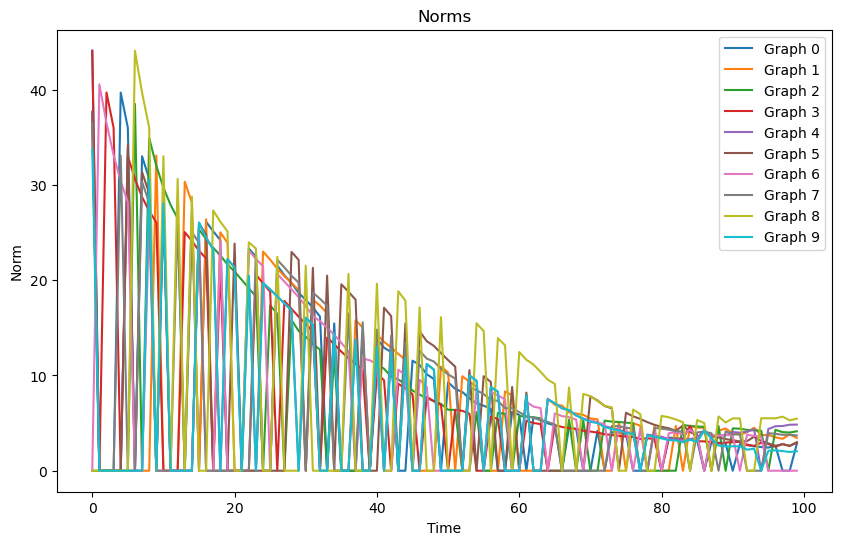

In [13]:
plt.figure(figsize=(10, 6))

for i, norm in enumerate(norms):
    plt.plot(norm.cpu().detach()[:100], label=f'Graph {i}')

plt.xlabel('Time')
plt.ylabel('Norm')
plt.title('Norms')
plt.legend()
plt.show()

In [14]:
dim_red = 50
method = None #'TruncatedSVD'

# compute local Koopman operator
train_X, val_X, train_y, val_y = train_test_split(X, states.targets, test_size=0.2, random_state=42)
kann_ = KANN(train_X.cpu(), k=dim_red, emb=method)

K0 = kann_.compute_KOP()

In [15]:
K0.shape

(80, 80)

In [16]:
pred_X = []
s = val_X[:,0,:]

for t in range(val_X.shape[1]):
    pred_X.append(s)
    s = s @ K0

pred_X = torch.stack(pred_X, dim=1)

In [17]:
pred_y = classifier.predict(pred_X[:, -1, :].cpu().detach().numpy())

accuracy = accuracy_score(val_y, pred_y)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5376884422110553


Using PyDMD library

In [ ]:
from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

In [34]:
X.shape

torch.Size([995, 106, 80])

### ... with SVD

In [30]:
dim_red = 50
method = 'TruncatedSVD'

# compute local Koopman operator
kann_ = KANN(train_X.cpu(), k=dim_red, emb=method)

K1 = kann_.compute_KOP()

In [31]:
K1.shape

(50, 50)

In [32]:
pred_X = []
s = kann_.emb_engine.transform(val_X[:,0,:])

for t in range(val_X.shape[1]):
    pred_X.append(torch.from_numpy(kann_.emb_engine.inverse_transform(s)))
    s = s @ K1

pred_X = torch.stack(pred_X, dim=1)

In [33]:
pred_y = classifier.predict(pred_X[:, -1, :].cpu().detach().numpy())

accuracy = accuracy_score(val_y, pred_y)
print(f"Accuracy: {accuracy}")

Accuracy: 0.542713567839196


## ... at node level

In [20]:
states.shape

torch.Size([200, 864, 170])

# Training DynGESN

In [3]:
import tsl

from dataset.utils import load_FB
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

In [4]:
edge_indexes, node_labels, graph_labels = load_FB(config['add_self_loops'])

In [22]:
data = []

for n in tqdm(range(len(node_labels))):
    data.append(
                tsl.data.data.Data(
                        input={'x': node_labels[n]},
                        target={'y': graph_labels[n]},
                        edge_index=edge_indexes[n]
                    ).to(device)
                )

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

batch_size = 1
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 995/995 [00:03<00:00, 265.98it/s]


In [15]:
from models.DynGraphESN import DynGESNModel
import torch
import torch.nn as nn

# Define the linear model
class DGESN(nn.Module):
    def __init__(self, reservoir, input_size, output_size):
        super(DGESN, self).__init__()
        self.reservoir = reservoir
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        h = self.reservoir(x.input.x, x.edge_index, None).sum(dim=1)[-1,:,:]
        h = rearrange(h, 'l h -> (l h)')
        return self.linear(h)

model = DynGESNModel(input_size=1,
                    reservoir_size=config['reservoir_size'],
                    input_scaling=config['input_scaling'],
                    reservoir_layers=config['reservoir_layers'],
                    leaking_rate=config['leaking_rate'],
                    spectral_radius=config['spectral_radius'],
                    density=config['density'],
                    reservoir_activation=config['reservoir_activation'],
                    alpha_decay=config['alpha_decay'],
                    requires_grad=True,
                    b_leaking_rate=config['b_leaking_rate']).to(device)

classifier = DGESN(model, input_size=config['reservoir_size']*config['reservoir_layers'],
                              output_size=1).to(device)

In [23]:
from tqdm import trange
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=config['lr'])

classifier.train()

# Iterate over the training data
for epoch in range(10):
    running_loss = 0.0
    
    for i in trange(len(train_dataloader)):
        data = next(iter(train_dataloader))
        labels = data.target.y
        optimizer.zero_grad()
        outputs = classifier(data)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_dataloader)}")

100%|██████████| 796/796 [04:48<00:00,  2.76it/s]


Epoch 1 - Loss: 68.4748161085292


100%|██████████| 796/796 [04:47<00:00,  2.77it/s]


Epoch 2 - Loss: 53.60696193479003


100%|██████████| 796/796 [04:45<00:00,  2.79it/s]


Epoch 3 - Loss: 53.932261355036694


100%|██████████| 796/796 [04:49<00:00,  2.75it/s]


Epoch 4 - Loss: 41.196986424951504


100%|██████████| 796/796 [04:40<00:00,  2.84it/s]


Epoch 5 - Loss: 42.304487752859586


100%|██████████| 796/796 [04:39<00:00,  2.84it/s]


Epoch 6 - Loss: 45.95686113318829


100%|██████████| 796/796 [04:43<00:00,  2.81it/s]


Epoch 7 - Loss: 74.37339865852643


100%|██████████| 796/796 [04:45<00:00,  2.79it/s]


Epoch 8 - Loss: 106.31799962519239


100%|██████████| 796/796 [04:46<00:00,  2.78it/s]


Epoch 9 - Loss: 78.68316799637638


100%|██████████| 796/796 [04:44<00:00,  2.80it/s]

Epoch 10 - Loss: 61.18746352456399


In [24]:
# Specify the path to save the model
model_path = "models/saved/classifier_model.pt"

# Save the model
torch.save(classifier.state_dict(), model_path)

In [ ]:
logger = TensorBoardLogger(save_dir="logs", name="dynGESN", version=0)
# %load_ext tensorboard
# %tensorboard --logdir logs

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.005, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
                    fast_dev_run=True,
                    max_epochs=config['epochs'],
                    # logger=logger,
                    # profiler="simple",
                    # limit_train_batches=0.1, 
                    # limit_val_batches=0.1,
                    devices=1, 
                    accelerator="gpu" if torch.cuda.is_available() else "cpu",
                    # limit_train_batches=50,  # end an epoch after 10 updates
                    # limit_val_batches=50,  # end an epoch after 10 updates
                    callbacks=[checkpoint_callback, early_stop_callback])

trainer.fit(model=classifier, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)